In [2]:
import time
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import random

import sys
sys.path.append('../')
from cnn.commons import inc_convolution
from cnn.commons import inc_max_pool

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Theoretical and Eperical Speedups

In [3]:
batch_size = 128
in_channels = 64
in_size = 224
out_channels = in_channels
out_size = in_size
k_size = 3

conv = True

In [9]:

theoretical_speedup = []
emperical_speedup = []
best_achievable_speedup = []
cudnn_speedup = []

in_tensor = torch.FloatTensor(batch_size, in_channels,  in_size, in_size).random_(0, 10)
weights = torch.FloatTensor(out_channels, in_channels, k_size, k_size).random_(0, 10)
biases = torch.FloatTensor(out_channels).random_(0, 10)

in_tensor, weights, biases = in_tensor.cuda(), weights.cuda(), biases.cuda()

conv_module = torch.nn.Conv2d(in_channels, out_channels, k_size, padding=1, stride=1).cuda()
conv_module.weight.data = weights
conv_module.bias.data = biases
conv_module = torch.nn.Sequential(conv_module, torch.nn.ReLU(inplace=True))
max_pool_module = torch.nn.MaxPool2d(kernel_size=2, stride=2)

in_tensor, weights, biases = Variable(in_tensor), Variable(weights), Variable(biases)


#full inference
if conv:
    temp = conv_module(in_tensor)
else:
    temp = max_pool_module(in_tensor)
    
torch.cuda.synchronize()
prev_time = time.time()
for i in range(5):
    if conv:
        out_ptch = conv_module(in_tensor)
    else:
        out_ptch = max_pool_module(in_tensor)
    torch.cuda.synchronize()
torch.cuda.synchronize()
full_time = (time.time()-prev_time)/5/batch_size

x = range(1, in_size//2, k_size-1)
x_label = []

for p_size in x:
    
    #sanity check
    if p_size >= in_size:
        continue
    else:
        x_label.append(p_size)

    x_loc = [random.choice(range(0, in_size-p_size)) for _ in range(batch_size)]
    y_loc = [random.choice(range(0, in_size-p_size)) for _ in range(batch_size)]
    locations = zip(x_loc, y_loc)
    #locations = [(1,1), (1,5)]
    
    #patch size equvalient full inference
    in_tensor_prime = Variable(torch.FloatTensor(batch_size, in_channels,  p_size+(k_size-1), p_size+(k_size-1)).fill_(1.0).cuda())
    if conv:
        conv_module(in_tensor_prime)
    else:
        max_pool_module(in_tensor_prime)
        
    torch.cuda.synchronize()
    prev_time = time.time()
    for i in range(10):
        if conv:
            conv_module(in_tensor_prime)
        else:
            max_pool_module(in_tensor_prime)
        torch.cuda.synchronize()
    torch.cuda.synchronize()
    inc_best_time = (time.time()-prev_time)/10/batch_size
    
    #incremental inference
    patch_location_tensor = torch.from_numpy(np.array(locations, dtype=np.int32)).cuda()
    if conv:
        inc_convolution(in_tensor.data, weights.data, biases.data, out_ptch.data, patch_location_tensor, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)
    else:
        inc_max_pool(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size)
    torch.cuda.synchronize()
    prev_time = time.time()
    for i in range(10):
        patch_location_tensor = torch.from_numpy(np.array(locations, dtype=np.int32)).cuda()
        if conv:
            inc_convolution(in_tensor.data, weights.data, biases.data, out_ptch.data, patch_location_tensor, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)
        else:
            inc_max_pool(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size, version=1)

        torch.cuda.synchronize()
    torch.cuda.synchronize()
    empr_time = (time.time()-prev_time)/10/batch_size
    
    #_, output_size = inc_conv_module(in_tensor, weights, biases, out_ptch, patch_location_tensor, 1, 1, k_size, p_height=p_size, p_width=p_size, version=4)
    #print(output_size)
    
    theoretical_speedup.append(1.0*out_size*out_size/(p_size+k_size-1)**2)
    best_achievable_speedup.append(full_time/inc_best_time)
    emperical_speedup.append(full_time/empr_time)

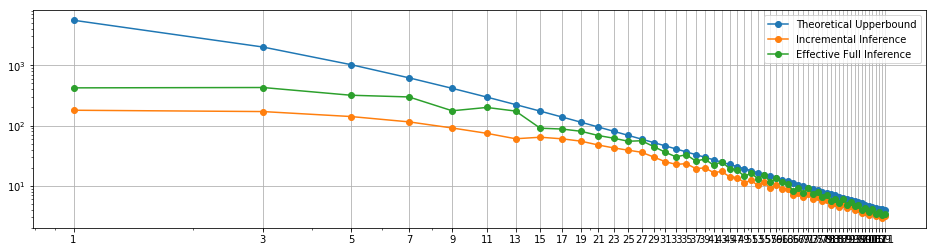

In [10]:
plt.rcParams["figure.figsize"] = (16,4)

plt.xscale('log')
plt.yscale('log')
plt.plot(x_label, theoretical_speedup, label='Theoretical Upperbound', marker='o')
plt.plot(x_label, emperical_speedup, label='Incremental Inference', marker='o')
plt.plot(x_label, best_achievable_speedup, label='Effective Full Inference', marker='o')
plt.xticks(x_label, x_label)
plt.legend()
plt.grid()
plt.show()

In [11]:
zip(x_label, theoretical_speedup, best_achievable_speedup, emperical_speedup)

[(1, 5575.111111111111, 422.15214619634503, 179.67332911277921),
 (3, 2007.04, 427.78811369509043, 170.865055474327),
 (5, 1024.0, 318.52621452621446, 141.30791663702965),
 (7, 619.4567901234568, 298.4747596153846, 115.30168311085316),
 (9, 414.6776859504132, 176.01204926021086, 91.26460859977948),
 (11, 296.89940828402365, 199.86398390342052, 74.46206896551723),
 (13, 223.00444444444443, 174.06886883378604, 60.50765997624341),
 (15, 173.61937716262975, 90.5285030758715, 64.12886148681365),
 (17, 138.99168975069253, 87.71460108614066, 60.40647044514716),
 (19, 113.77777777777777, 80.49953401677539, 55.21073840424644),
 (21, 94.85066162570888, 68.47676823383428, 47.66544302886346),
 (23, 80.2816, 61.706724646684265, 42.598108797735705),
 (25, 68.82853223593965, 54.972412075597, 39.090315217819054),
 (27, 59.66230677764566, 56.099398525965036, 36.14584622102544),
 (29, 52.21227887617066, 44.823067551103286, 30.054279749478077),
 (31, 46.0752984389348, 36.093310562842916, 25.1687887195469

In [ ]:
np.sum(np.abs((temp-out_ptch).cpu().data.numpy().flatten()))

In [ ]:
#temp
#out_ptch
#temp-out_ptch
#patch_location_tensor